<a href="https://colab.research.google.com/github/nastaranmarzban/BGAT-and-GAT-Jupyter-notebook/blob/main/BGAT_5classes_200nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to gdrive to read data, adjacency matrix, p_link and labels.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
!pip install kneed
import pandas as pd
import torch
import numpy as np
import time

# Load data which are processed in preprocessing data_5classes_200nodes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/5classes_200_non.sim/data.pt"
Data = torch.load(path)
Data

<ipython-input-3-118d2bf10472>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Data = torch.load(path)


{'x': tensor([[ 0.1064,  0.0268,  0.0688,  ...,  0.1277,  0.0208,  0.0365],
         [-1.1319,  0.0287, -1.2385,  ..., -0.1471,  1.4365, -0.7657],
         [ 0.5656,  1.3512,  2.0302,  ...,  1.2031, -1.7998,  1.0181],
         ...,
         [-0.0979,  0.9709,  0.6932,  ..., -0.8765, -0.6086, -0.5979],
         [ 1.9060, -0.2760,  1.1493,  ..., -1.1248,  0.7692,  0.6333],
         [ 1.1451, -1.8192, -2.0841,  ...,  1.7384, -0.7770, -0.3205]]),
 'edge_index': tensor([[  0,   0,   0,  ..., 199, 199, 199],
         [  9,  12,  20,  ...,  90, 100, 174]]),
 'y': tensor([2, 3, 4, 4, 4, 4, 0, 4, 4, 2, 3, 4, 1, 0, 2, 3, 1, 4, 3, 0, 0, 1, 1, 1,
         1, 2, 4, 3, 1, 4, 1, 4, 0, 0, 2, 3, 0, 4, 1, 1, 3, 0, 0, 0, 1, 3, 4, 1,
         3, 3, 0, 4, 2, 4, 4, 3, 3, 2, 2, 2, 3, 4, 4, 2, 4, 4, 3, 0, 4, 0, 3, 3,
         0, 0, 1, 2, 4, 2, 0, 4, 4, 4, 2, 0, 0, 2, 0, 4, 0, 2, 3, 3, 2, 2, 3, 2,
         2, 4, 4, 3, 3, 1, 1, 1, 0, 0, 2, 1, 2, 0, 0, 3, 3, 2, 1, 3, 3, 2, 1, 4,
         0, 1, 3, 2, 3, 0, 4, 4, 

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 200
Number of features: 500
Number of classes: 5
Number of edges: 1790
Average node degree: 8.95
Number of training nodes: 160
Number of testing nodes: 20
Training node label rate: 0.80


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/5classes_200_non.sim/p_link.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([200, 200])
torch.float32
torch.FloatTensor


<ipython-input-5-0572c7641c16>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  p_link = torch.load(path)


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Developing my own model (making our own message passing layers), which name is BGAT.

**BGATConv**
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph (p_link) and $\Theta$ is learnable parameter


In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use three BGAT conv

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 500, out_channels = 15)
        self.conv2 =  BGATConv(15, 5)


    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        return h

model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(500, 15)
  (conv2): BGATConv(15, 5)
)
tensor([[ 2.1293e+00,  5.7953e-01,  7.9458e-01, -2.6776e+00,  3.8019e-01],
        [-1.1192e+00, -2.1002e-01,  2.8241e+00, -8.8894e-01,  1.6564e+00],
        [ 9.2704e-01,  1.6865e+00, -1.2808e+00, -2.2344e-01,  1.3138e+00],
        [-4.0488e-01,  6.2004e-01, -2.5906e-02,  1.2410e+00,  3.5720e-01],
        [ 1.2185e-01, -1.0387e+00,  1.0315e+00,  6.7436e-01,  1.9069e+00],
        [-2.0061e-01,  2.6011e+00, -1.3580e+00,  2.0816e+00,  1.4664e+00],
        [ 5.1985e-01, -3.3965e+00, -1.9293e+00, -1.9707e+00,  2.1323e+00],
        [ 1.0053e+00,  3.8456e-01,  3.5055e+00, -5.6903e-01,  4.9274e-01],
        [ 3.2808e-01,  6.6424e-01, -7.2094e-01,  9.3730e-01,  1.5317e+00],
        [ 1.3183e+00, -1.3744e+00,  1.6096e-01, -2.2784e+00,  5.3167e-01],
        [-6.6250e-01,  5.9416e-02,  1.0683e+00, -8.6587e-01,  1.2286e+00],
        [ 1.9543e+00,  9.0314e-03,  3.2853e-01, -4.4265e-01,  8.4903e-01],
        [-2.4369e+00, -2.0925e+00,

# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection before training (BGAT)")

Here, we pass in the initial node features x and the graph connectivity information edge_index to the model, and visualize its 2-dimensional embedding

Embedding shape: [200, 5]


<ipython-input-10-8bde51ee94e9>:8: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",7)).set(title = "Second scenario data T-SNE projection before training (BGAT)")


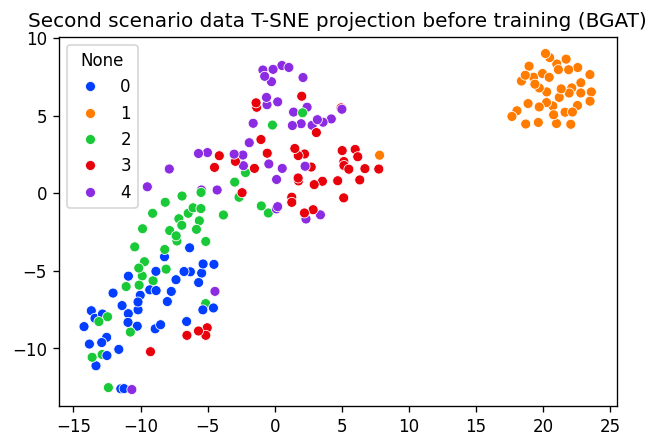

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model.

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        return val_loss

In [ ]:
train_loss_ = []
val_loss_ = []

# Start timer before training begins
start_time = time.time()

for epoch in range(1, 59):
    # Start timer for the epoch
    epoch_start_time = time.time()

    # Initialize lists to track forward and backward pass times
    forward_times = []
    backward_times = []

    epoch_train_loss = []
    epoch_val_loss = []

    # Training
    model.train()
    optimizer.zero_grad()  # Clear gradients

    # Measure forward pass time
    forward_start = time.time()
    out = model(Data["x"], Data["edge_index"])  # Forward pass
    forward_end = time.time()

    # Compute loss
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])

    # Measure backward pass time
    backward_start = time.time()
    train_loss.backward()  # Backward pass
    optimizer.step()  # Update parameters
    backward_end = time.time()

    # Record forward and backward pass times
    forward_times.append(forward_end - forward_start)
    backward_times.append(backward_end - backward_start)

    # Record training loss
    epoch_train_loss.append(train_loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        epoch_val_loss.append(val_loss.item())

    # Append epoch-wise average loss
    train_loss_.append(sum(epoch_train_loss) / len(epoch_train_loss))
    val_loss_.append(sum(epoch_val_loss) / len(epoch_val_loss))

    # End timer for the epoch
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    # Log losses and times
    print(epoch,
      f'Train Loss: {train_loss_[-1]:.3f} | Val Loss: {val_loss_[-1]:.3f} | '
      f'Forward Time: {np.mean(forward_times):.4f}s | Backward Time: {np.mean(backward_times):.4f}s | '
      f'Epoch Time: {epoch_time:.2f}s')

# End timer after training completes
end_time = time.time()
total_training_time = end_time - start_time

print(f"Total training time: {total_training_time/59:.2f} seconds")



1 Train Loss: 4.215 | Val Loss: 2.767 | Forward Time: 0.0021s | Backward Time: 0.0029s | Epoch Time: 0.01s
2 Train Loss: 1.683 | Val Loss: 2.007 | Forward Time: 0.0030s | Backward Time: 0.0017s | Epoch Time: 0.01s
3 Train Loss: 1.461 | Val Loss: 0.985 | Forward Time: 0.0026s | Backward Time: 0.0016s | Epoch Time: 0.01s
4 Train Loss: 0.736 | Val Loss: 0.935 | Forward Time: 0.0027s | Backward Time: 0.0027s | Epoch Time: 0.01s
5 Train Loss: 0.680 | Val Loss: 0.934 | Forward Time: 0.0029s | Backward Time: 0.0016s | Epoch Time: 0.01s
6 Train Loss: 0.655 | Val Loss: 0.757 | Forward Time: 0.0023s | Backward Time: 0.0016s | Epoch Time: 0.01s
7 Train Loss: 0.550 | Val Loss: 0.523 | Forward Time: 0.0013s | Backward Time: 0.0015s | Epoch Time: 0.01s
8 Train Loss: 0.436 | Val Loss: 0.359 | Forward Time: 0.0023s | Backward Time: 0.0015s | Epoch Time: 0.01s
9 Train Loss: 0.364 | Val Loss: 0.300 | Forward Time: 0.0022s | Backward Time: 0.0015s | Epoch Time: 0.01s
10 Train Loss: 0.338 | Val Loss: 0.30

# Visualize train loss and val loss.

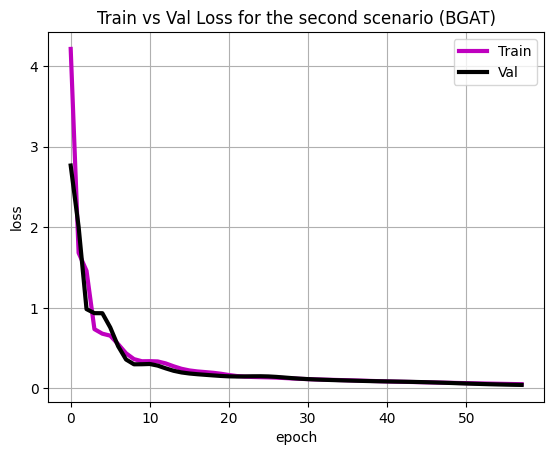

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the second scenario (BGAT)')
plt.grid()
plt.show()

Elbow Point (Optimal Epoch): 9


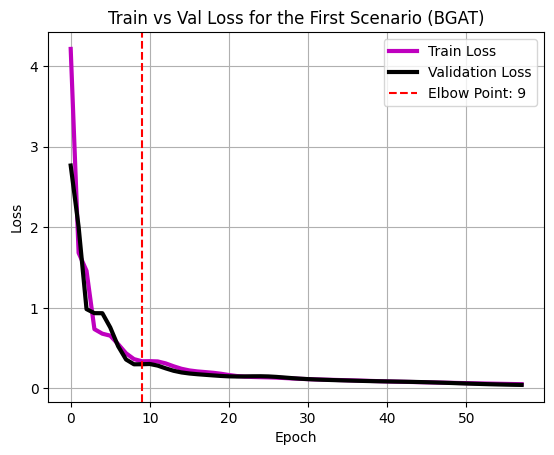

In [ ]:
from kneed import KneeLocator

# Plot training and validation loss
plt.plot(train_loss_, "m", linewidth=3, label="Train Loss")
plt.plot(val_loss_, "k", linewidth=3, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss for the First Scenario (BGAT)')
plt.legend()
plt.grid()

# Identify the elbow point
epochs = list(range(1, len(train_loss_) + 1))
knee_locator = KneeLocator(epochs, val_loss_, curve='convex', direction='decreasing')
elbow_epoch = knee_locator.knee
print(f"Elbow Point (Optimal Epoch): {elbow_epoch}")

# Highlight the elbow point on the plot
plt.axvline(x=elbow_epoch, color='r', linestyle='--', label=f'Elbow Point: {elbow_epoch}')
plt.legend()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc

In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 95.00


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",5)).set(title = "Second scenario data T-SNE projection after training (BGAT)")

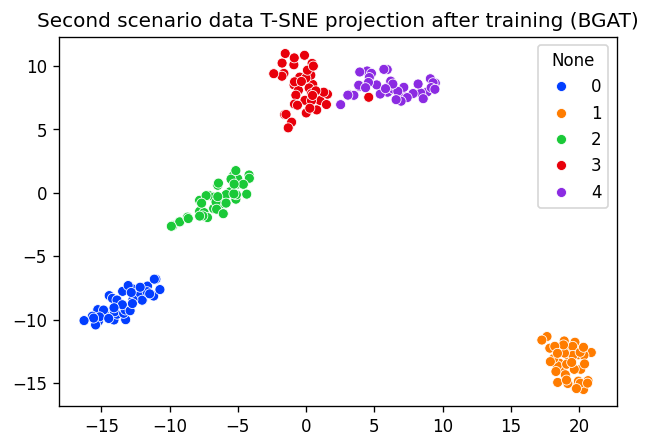

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred_t = out.argmax(dim=1)
pred_t

tensor([2, 3, 4, 4, 4, 4, 0, 4, 4, 2, 3, 4, 1, 0, 2, 3, 1, 4, 3, 0, 0, 1, 1, 1,
        1, 2, 4, 3, 1, 4, 1, 4, 0, 0, 2, 3, 0, 4, 1, 1, 3, 0, 0, 0, 1, 3, 4, 1,
        3, 3, 0, 4, 2, 4, 4, 3, 3, 2, 2, 2, 3, 4, 4, 2, 4, 4, 3, 0, 4, 0, 3, 3,
        0, 0, 1, 2, 4, 2, 0, 4, 4, 4, 2, 0, 0, 2, 0, 4, 0, 2, 3, 3, 2, 2, 3, 2,
        2, 4, 4, 3, 3, 1, 1, 1, 0, 0, 2, 1, 2, 0, 0, 3, 3, 2, 1, 4, 3, 2, 1, 4,
        0, 1, 3, 2, 3, 0, 4, 4, 0, 1, 2, 1, 3, 1, 4, 3, 2, 3, 4, 1, 4, 0, 1, 1,
        2, 1, 2, 0, 3, 1, 2, 2, 2, 2, 3, 0, 4, 1, 2, 1, 2, 0, 0, 3, 0, 0, 0, 1,
        1, 3, 1, 0, 1, 1, 3, 1, 4, 2, 2, 2, 1, 0, 3, 4, 1, 3, 0, 3, 0, 1, 4, 2,
        0, 1, 2, 1, 2, 4, 3, 3])

In [ ]:
Data["y"]

tensor([2, 3, 4, 4, 4, 4, 0, 4, 4, 2, 3, 4, 1, 0, 2, 3, 1, 4, 3, 0, 0, 1, 1, 1,
        1, 2, 4, 3, 1, 4, 1, 4, 0, 0, 2, 3, 0, 4, 1, 1, 3, 0, 0, 0, 1, 3, 4, 1,
        3, 3, 0, 4, 2, 4, 4, 3, 3, 2, 2, 2, 3, 4, 4, 2, 4, 4, 3, 0, 4, 0, 3, 3,
        0, 0, 1, 2, 4, 2, 0, 4, 4, 4, 2, 0, 0, 2, 0, 4, 0, 2, 3, 3, 2, 2, 3, 2,
        2, 4, 4, 3, 3, 1, 1, 1, 0, 0, 2, 1, 2, 0, 0, 3, 3, 2, 1, 3, 3, 2, 1, 4,
        0, 1, 3, 2, 3, 0, 4, 4, 0, 1, 2, 1, 3, 1, 4, 3, 2, 3, 4, 1, 4, 0, 1, 1,
        2, 1, 2, 0, 3, 4, 2, 2, 2, 2, 3, 0, 4, 1, 2, 1, 2, 0, 0, 3, 0, 0, 0, 1,
        1, 3, 1, 0, 1, 1, 3, 1, 4, 2, 2, 2, 1, 0, 3, 4, 1, 3, 0, 3, 0, 1, 4, 2,
        0, 1, 2, 1, 2, 4, 3, 3])

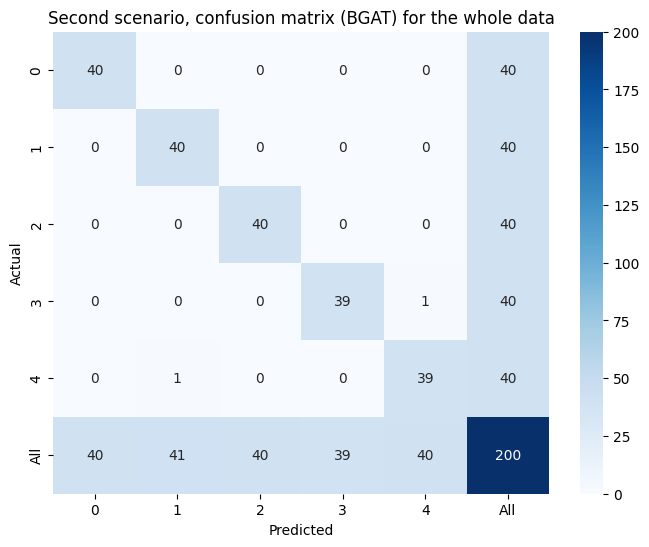

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(Data['y'], pred_t, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Second scenario, confusion matrix (BGAT) for the whole data')
plt.show()

In [ ]:
pred = pred_t[Data["test_mask"]]

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,0,0
1,3,3
2,0,0
3,2,2
4,4,4
5,2,2
6,0,0
7,1,1
8,4,4
9,4,4


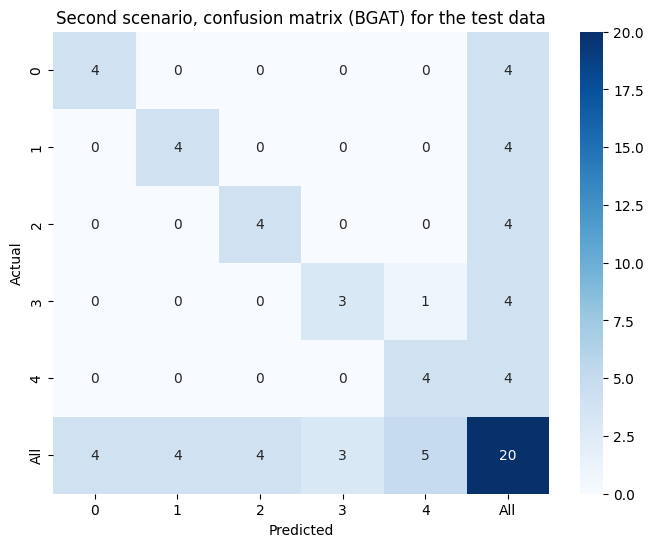

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(act, pred, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Second scenario, confusion matrix (BGAT) for the test data')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score
# Assuming these are your predicted and true labels in PyTorch tensors
y_pred = pred_t
y_true = Data["y"]

# Convert predicted and true labels to NumPy arrays
out = model(Data["x"], Data["edge_index"])
pred = out.argmax(dim = 1)
y_pred_np = pred[Data["test_mask"]]

y_true_np = Data["y"][Data["test_mask"]]
# Calculate F-score and recall per class
f_score = f1_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')

print(f'F-score: {f_score:.3f}')
print(f'Recall: {recall:.3f}')

F-score: 0.949
Recall: 0.950


In [ ]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_true_np, y_pred_np)

print(f'Cohen\'s Kappa: {kappa:.3f}')

Cohen's Kappa: 0.938


In [ ]:
from sklearn.metrics import precision_score
average_precision = precision_score(y_true_np, y_pred_np, average='macro')
print(f'Average Precision: {average_precision:.3f}')

Average Precision: 0.960
